# How do different input data transformations affect model outcome?
My goal with this notebook is to find out how different data preprocessing techniques affect the model's evaluation metric.

**My experiment:**
* Use one model with a fixed set of hyperparameters. I chose LightGBM with these parameters:
> lgb_params = {
    'objective': 'binary',
    'n_estimators': 1000,
    'random_state': 29,
    'learning_rate': 0.1,
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.4,
    'reg_alpha': 10.0,
    'reg_lambda': 1e-1,
    'min_child_weight': 256,
    'min_child_samples': 20,
}
* Use exactly the same features
* Fix the random state
* Vary the preprocessing technique
    * Step 1: replace missing values with column mean (rmv)
    * Step 2: rvm + different scalers/transformers applied to all features
    * Step 2a: rmv + StandardScaler 
    * Step 2b: rmv + MinMaxScaler
    * Step 2c: rmv + RobustScaler
    * Step 2d: rmv + PowerTransformer
    * Step 2e: rmv + QuantileTransformer
    * Step 3: rmv + different Scalers on different features
    * Step 4a: rmv + adding categorical version of f40,f42,f65,f70,f75
    * Step 4b: rmv + making f40,f42,f65,f70,f75 categorical
   
**My conclusions:**

* My experiment did not have a big impact on the validation score. The best result gave using PowerTransformer on all features. The more experimental Steps 3 and 4 led to a worse score. 
* On the bright side, I finally learned how to use Pipelines for preprocessing.

----
**I'd appreciate your feedback and ideas. Let's share our knowledge so that we can all learn something new!**


In [18]:
#load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

import lightgbm as lgb
print("LightGBM version:  {}".format(lgb.__version__))

import matplotlib as plt
print("Matplotlib version:  {}".format(plt.__version__))

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

LightGBM version:  3.2.1
Matplotlib version:  3.4.3
/kaggle/input/tabular-playground-series-sep-2021/train.csv
/kaggle/input/tabular-playground-series-sep-2021/test.csv
/kaggle/input/tabular-playground-series-sep-2021/sample_solution.csv


In [19]:
# read input files
df_train = pd.read_csv("../input/tabular-playground-series-sep-2021/train.csv")
df_test = pd.read_csv("../input/tabular-playground-series-sep-2021/test.csv")
sample_submission = pd.read_csv("../input/tabular-playground-series-sep-2021/sample_solution.csv")

feature_cols = [col for col in df_train.columns if col.startswith("f")]
target=df_train.claim

## Steps 1 and 2

In [21]:
# define preprocessing pipelines, different pipelines are used for the different steps
cat_like_features = ['f40','f42','f65','f70','f75']
numeric_features = list(set(feature_cols).difference(cat_like_features)) # all features that are not in cat_like_features

numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean')), # replace all Nan with mean
       ('scaler', PowerTransformer()) # scale the features, remove/change the scaler here for Steps 1 and 2
        ]) 

cat_like_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean')), 
       ('scaler', StandardScaler())
        ]) 

preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,('cat_like', cat_like_transformer, cat_like_features)
]) 

In [29]:
# dividing X, y into train and test data
X = df_train[feature_cols]
y = df_train.claim
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 29, stratify=y)
display(X_train.shape)

(718439, 118)

In [30]:
X_train1 = numeric_transformer.fit_transform(X_train)
X_val1 = numeric_transformer.transform(X_val)

In [31]:
# most of the parameters I borrowed from BIZENs great notebook: https://www.kaggle.com/hiro5299834/tps-sep-2021-single-lgbm
# this parameterset is kept fixed for my experiment
lgb_params = {
    'objective': 'binary',
    'n_estimators': 1000,
    'random_state': 29,
    'learning_rate': 0.1,
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.4,
    'reg_alpha': 10.0,
    'reg_lambda': 1e-1,
    'min_child_weight': 256,
    'min_child_samples': 20,
}

In [32]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit( 
        X_train1, 
        y_train,
        eval_set=[(X_val1, y_val)],
        eval_names=['val'],
        eval_metric='auc',
        #early_stopping_rounds=30, # no early stopping for my experiment
        verbose=100)

[100]	val's auc: 0.762632	val's binary_logloss: 0.630107
[200]	val's auc: 0.784172	val's binary_logloss: 0.600869
[300]	val's auc: 0.788791	val's binary_logloss: 0.588506
[400]	val's auc: 0.79088	val's binary_logloss: 0.582312
[500]	val's auc: 0.791616	val's binary_logloss: 0.579484
[600]	val's auc: 0.791802	val's binary_logloss: 0.577965
[700]	val's auc: 0.791771	val's binary_logloss: 0.577137
[800]	val's auc: 0.791557	val's binary_logloss: 0.576675
[900]	val's auc: 0.791304	val's binary_logloss: 0.576379
[1000]	val's auc: 0.791065	val's binary_logloss: 0.576157


LGBMClassifier(colsample_bytree=0.4, min_child_weight=256, n_estimators=1000,
               objective='binary', random_state=29, reg_alpha=10.0,
               reg_lambda=0.1, subsample=0.6, subsample_freq=1)

In [33]:
# LGBM Results
# Part 1
# LGBM with no missing values (SimpleImputer(strategy='mean'))
#[1000]	val's auc: 0.790365	val's binary_logloss: 0.576905

# Part 2
# LGBM with no missing values (SimpleImputer(strategy='mean')) and all features standard scaled
#[1000]	val's auc: 0.793513	val's binary_logloss: 0.574752
# LGBM with no missing values (SimpleImputer(strategy='mean')) and all features MinMax scaled
#[1000]	val's auc: 0.790635	val's binary_logloss: 0.576583
# LGBM with no missing values (SimpleImputer(strategy='mean')) and all features robust scaled
#[1000]	val's auc: 0.790691	val's binary_logloss: 0.576554
# LGBM with no missing values (SimpleImputer(strategy='mean')) and all features power transformed
#[1000]	val's auc: 0.791065	val's binary_logloss: 0.576157
# LGBM with no missing values (SimpleImputer(strategy='mean')) and all features quantile transformed, normal distribution
#[1000]	val's auc: 0.790998	val's binary_logloss: 0.576303

In [34]:
#pred_val = model.predict_proba(X_val)[:,1]
#pred_val[0:5] 
#roc_auc_score(y_val, pred_val) 

## Step 3: Changing the preprocessing, different preprocessing for different features

In [35]:
X_train2 = preprocessor.fit_transform(X_train)
X_val2 = preprocessor.transform(X_val)

In [36]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit( 
        X_train2, 
        y_train,
        eval_set=[(X_val2, y_val)],
        eval_names=['val'],
        eval_metric='auc',
        #early_stopping_rounds=30, # no early stopping for my experiment
        verbose=100)

[100]	val's auc: 0.761026	val's binary_logloss: 0.630649
[200]	val's auc: 0.783413	val's binary_logloss: 0.601298
[300]	val's auc: 0.789027	val's binary_logloss: 0.588229
[400]	val's auc: 0.790773	val's binary_logloss: 0.582434
[500]	val's auc: 0.791611	val's binary_logloss: 0.579407
[600]	val's auc: 0.791789	val's binary_logloss: 0.577908
[700]	val's auc: 0.791885	val's binary_logloss: 0.57707
[800]	val's auc: 0.791562	val's binary_logloss: 0.576681
[900]	val's auc: 0.791339	val's binary_logloss: 0.576439
[1000]	val's auc: 0.790866	val's binary_logloss: 0.576427


LGBMClassifier(colsample_bytree=0.4, min_child_weight=256, n_estimators=1000,
               objective='binary', random_state=29, reg_alpha=10.0,
               reg_lambda=0.1, subsample=0.6, subsample_freq=1)

In [37]:
# LGBM Results
#[1000]	val's auc: 0.790365	val's binary_logloss: 0.576905 (from Part1)
#[1000]	val's auc: 0.791065	val's binary_logloss: 0.576157 (from Part2, all power transformed)
#[1000]	val's auc: 0.790866	val's binary_logloss: 0.576427 Power Transform on all "non cat_like_features"

## Step 4: make a few features categorical

In [38]:
# fill means before, otherwise there would be Nans in qcut
df_train[feature_cols] = df_train[feature_cols].fillna(df_train[feature_cols].mean())

In [39]:
# Steps 4a, 4b: make categorical features, made auc worse, don't use
df_train['f40c'] = pd.cut(df_train['f40'], bins=2, labels=[0,1]).astype(int)
df_train['f42c'] = pd.cut(df_train['f42'], bins=3, labels=[0,1,2]).astype(int)
df_train['f65c'] = pd.cut(df_train['f65'], bins=2, labels=[0,1]).astype(int)
df_train['f70c'] = pd.cut(df_train['f70'], bins=2, labels=[0,1]).astype(int)
df_train['f75c'] = pd.cut(df_train['f75'], bins=2, labels=[0,1]).astype(int)
# renew feature col list
feature_cols = [col for col in df_train.columns if col.startswith("f")]

In [40]:
# dividing X, y into train and test data
X = df_train[feature_cols]
y = df_train.claim
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 29, stratify=y)
display(X_train.shape)

(718439, 123)

In [41]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit( 
        X_train, 
        y_train,
        eval_set=[(X_val, y_val)],
        eval_names=['val'],
        eval_metric='auc',
        #early_stopping_rounds=30, # no early stopping for my experiment
        verbose=100)

[100]	val's auc: 0.760965	val's binary_logloss: 0.631146
[200]	val's auc: 0.782586	val's binary_logloss: 0.602316
[300]	val's auc: 0.787682	val's binary_logloss: 0.589283
[400]	val's auc: 0.789368	val's binary_logloss: 0.583512
[500]	val's auc: 0.790225	val's binary_logloss: 0.580595
[600]	val's auc: 0.790298	val's binary_logloss: 0.57916
[700]	val's auc: 0.790342	val's binary_logloss: 0.578337
[800]	val's auc: 0.790122	val's binary_logloss: 0.577791
[900]	val's auc: 0.79001	val's binary_logloss: 0.57739
[1000]	val's auc: 0.789607	val's binary_logloss: 0.577286


LGBMClassifier(colsample_bytree=0.4, min_child_weight=256, n_estimators=1000,
               objective='binary', random_state=29, reg_alpha=10.0,
               reg_lambda=0.1, subsample=0.6, subsample_freq=1)

In [42]:
# LGBM Results
#[1000]	val's auc: 0.790365	val's binary_logloss: 0.576905 (from Part 1)
#[1000]	val's auc: 0.789538	val's binary_logloss: 0.577241 (adding categorical version of f40,f42,f65,f70,f75)
#[1000]	val's auc: 0.787255	val's binary_logloss: 0.579993 (making f40,f42,f65,f70,f75 categorical)

In [43]:
#pred_val = model.predict_proba(X_val)[:,1]
#pred_val[0:5]  

# Understanding ROC curve
adapted from: https://www.projectpro.io/recipes/plot-roc-curve-in-python

In [44]:
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [45]:
dataset = datasets.load_breast_cancer()
X = dataset.data
y = dataset.target

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [47]:
clf_tree = RandomForestClassifier()
clf_tree.fit(X_train, y_train) 
y_score1 = clf_tree.predict_proba(X_test)[:,1]

In [48]:
print(y_score1[0:7]) # how confident the classifier is that the class is 1
print(y_test[0:7]) # the actual classes

[1.   0.17 0.2  0.   0.05 1.   1.  ]
[1 0 0 0 0 1 1]


In [49]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

In [50]:
print(false_positive_rate1)
print(true_positive_rate1)
print(threshold1)

[0.         0.         0.         0.         0.         0.
 0.         0.01851852 0.01851852 0.01851852 0.01851852 0.01851852
 0.03703704 0.03703704 0.03703704 0.07407407 0.07407407 0.09259259
 0.09259259 0.14814815 0.14814815 0.16666667 0.16666667 0.24074074
 0.27777778 0.31481481 0.38888889 0.42592593 0.5        0.62962963
 1.        ]
[0.         0.36752137 0.52991453 0.65811966 0.70940171 0.74358974
 0.76068376 0.77777778 0.81196581 0.84615385 0.86324786 0.88888889
 0.88888889 0.92307692 0.93162393 0.94017094 0.96581197 0.96581197
 0.98290598 0.98290598 0.99145299 0.99145299 1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]
[2.   1.   0.99 0.98 0.97 0.96 0.95 0.94 0.92 0.91 0.89 0.88 0.87 0.85
 0.79 0.77 0.68 0.64 0.6  0.43 0.41 0.36 0.31 0.21 0.2  0.15 0.08 0.04
 0.02 0.01 0.  ]


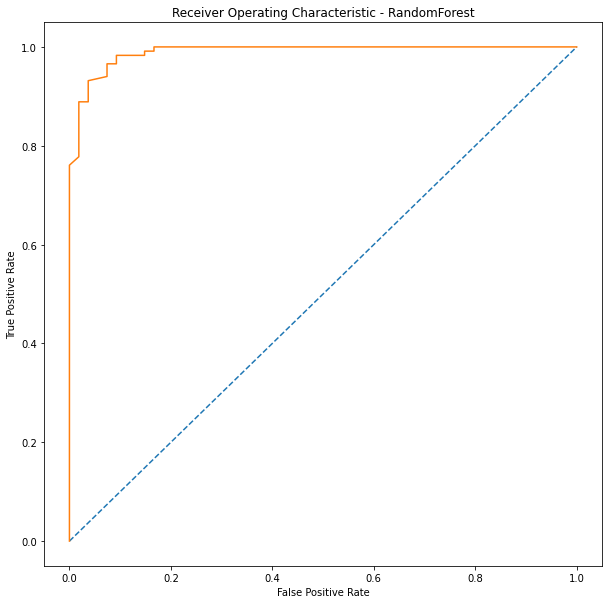

In [51]:
# Ploting ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - RandomForest')
plt.plot([0, 1], ls="--")
plt.plot(false_positive_rate1, true_positive_rate1)

#plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [52]:
 print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, y_score1))

roc_auc_score for Random Forest:  0.9895536562203229
